In [1]:
import igraph as ig
import numpy as np
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_mutual_info_score as AMI
import scipy.stats as ss
import pandas as pd

def community_ecg(self, weights=None, ens_size=32, min_weight=0.05):
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain 
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l[p[x.tuple[0]]]==l[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    part = self.community_multilevel(weights=W)
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    part.W = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    return part

ig.Graph.community_ecg = community_ecg

def readGraph(fn, directed=False):
    g = ig.Graph.Read_Ncol(fn+'.edgelist',directed=directed)
    c = np.loadtxt(fn+'.community',dtype='uint8')
    node_base = min([int(x['name']) for x in g.vs]) ## graphs have 1-based or 0-based nodes 
    comm_base = min(c) ## same for communities
    comm = [c[int(x['name'])-node_base]-comm_base for x in g.vs]
    g.vs['community'] = comm
    g.vs['shape'] = 'circle'
    pal = ig.RainbowPalette(n=max(comm)+1)
    g.vs['color'] = [pal.get(int(i)) for i in comm]
    g.vs['size'] = 10
    g.es['width'] = 1
    return g

In [2]:
def edgeLabels(g, gcomm):
    x = [(gcomm[x.tuple[0]]==gcomm[x.tuple[1]]) for x in g.es]
    return x
def AGRI(g, u, v):
    bu = edgeLabels(g, u)
    bv = edgeLabels(g, v)
    su = np.sum(bu)
    sv = np.sum(bv)
    suv = np.sum(np.array(bu)*np.array(bv))
    m = len(bu)
    return((suv-su*sv/m) / (0.5*(su+sv)- su*sv/m))
    #return suv/(0.5*(su+sv))


## ARI, AGRI

In [3]:
## large graph with mu = .48
g = readGraph('Data/LFR8916/lfr8916')
g = g.simplify()
print(1+np.max(g.vs['community']),'communities')

70 communities


In [4]:
ml = g.community_multilevel(return_levels=True)
l = len(ml)-1

print(1+np.max(ml[0].membership),'communities')
print('level 0 ARI:',ARI(g.vs['community'],ml[0].membership))
print('level 0 AGRI:',AGRI(g,g.vs['community'],ml[0].membership))
print('level 0 NMI:',NMI(g.vs['community'],ml[0].membership))

print('')

print(1+np.max(ml[1].membership),'communities')
print('last level ARI:',ARI(g.vs['community'],ml[l].membership))
print('last level AGRI:',AGRI(g,g.vs['community'],ml[l].membership))
print('last level NMI:',NMI(g.vs['community'],ml[l].membership))


93 communities
level 0 ARI: 0.8041120522301082
level 0 AGRI: 0.9727030368082258
level 0 NMI: 0.9192662488173526

32 communities
last level ARI: 0.7913769789156142
last level AGRI: 0.9725422501598854
last level NMI: 0.9015563472722934


/opt/software/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [5]:
im = g.community_infomap()
print(1+np.max(im.membership),'communities')
print('ARI:',ARI(g.vs['community'],im.membership))
print('AGRI:',AGRI(g,g.vs['community'],im.membership))
print('NMI:',NMI(g.vs['community'],im.membership))


224 communities
ARI: 0.901048789109451
AGRI: 0.962765591235264
NMI: 0.9278808042937791


In [6]:
ec = g.community_ecg()
print(1+np.max(ec.membership),'communities')
print('ARI:',ARI(g.vs['community'],ec.membership))
print('AGRI:',AGRI(g,g.vs['community'],ec.membership))
print('NMI:',NMI(g.vs['community'],ec.membership))


62 communities
ARI: 0.9760297980288017
AGRI: 0.9931563885839261
NMI: 0.9821526815415101


In [7]:
lp = g.community_label_propagation() ## highly variable
print(1+np.max(lp.membership),'communities')
print('ARI:',ARI(g.vs['community'],lp.membership))
print('AGRI:',AGRI(g,g.vs['community'],lp.membership))
print('NMI:',NMI(g.vs['community'],lp.membership))


59 communities
ARI: 0.6314724389925527
AGRI: 0.9438067724422815
NMI: 0.9085029786237804


## Topological features

In [8]:
## topological measures: scaled density and internal transitivity
#g = readGraph('Data/Football/football')
g = readGraph('Data/LFR8916/lfr8916')
g = g.simplify()
g.vs['ml'] = g.community_multilevel().membership
g.vs['im'] = g.community_infomap().membership
g.vs['ec'] = g.community_ecg().membership

In [9]:
def topo(G, measure='community'):
    sd = [] ## scaled density
    tr = [] ## internal transitivity
    sz = [] ## size
    x = G.vs[measure]
    for i in range(max(x)+1):
        ix = [v for v in G.vs if v[measure]==i]
        g = G.subgraph(ix)
        sd.append(2*g.ecount()/(g.vcount()-1))
        sz.append(g.vcount())
        tr.append(sum(g.transitivity_local_undirected(mode='zero'))/g.vcount())
    return sd,tr,sz

In [10]:
sd, tr, sz = topo(g)
sdm, trm, szm = topo(g,'ml')
sde, tre, sze = topo(g,'ec')
sdi, tri, szi = topo(g,'im')
xl = (min(sz+szm+szi+sze)-.1,max(sz+szm+szi+sze)+1)


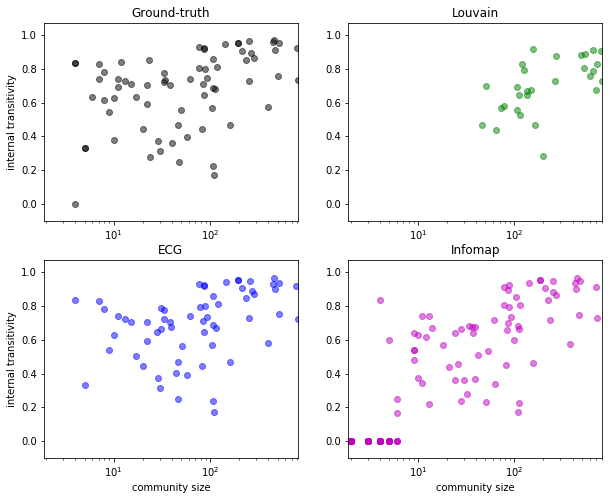

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(1, figsize=(10,8))

yl = (min(tr+trm+tri+tre)-.1,max(tr+trm+tri+tre)+.1)

plt.subplot(221)
plt.semilogx(sz,tr,'o',color='k', alpha=.5)
plt.xlim(xl)
plt.ylim(yl)
plt.ylabel('internal transitivity')
plt.title('Ground-truth')

plt.subplot(222)
plt.semilogx(szm,trm,'o',color='g', alpha=.5)
plt.xlim(xl)
plt.ylim(yl)
plt.title('Louvain')

plt.subplot(223)
plt.semilogx(sze,tre,'o',color='b', alpha=.5)
plt.xlim(xl)
plt.ylim(yl)
plt.ylabel('internal transitivity')
plt.title('ECG')
plt.xlabel('community size')

plt.subplot(224)
plt.semilogx(szi,tri,'o',color='m', alpha=.5)
plt.xlim(xl)
plt.ylim(yl)
plt.title('Infomap')
plt.xlabel('community size');
#fig.savefig('foot_transitivity.pdf')

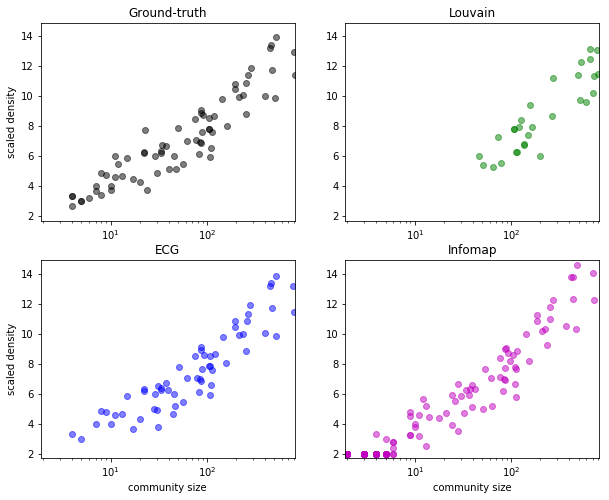

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(1, figsize=(10,8))

yl = (min(sd+sdm+sdi+sde)-.3,max(sd+sdm+sdi+sde)+.3)

plt.subplot(221)
plt.semilogx(sz,sd,'o',color='k', alpha=.5)
plt.xlim(xl)
plt.ylim(yl)
plt.ylabel('scaled density')
plt.title('Ground-truth')

plt.subplot(222)
plt.semilogx(szm,sdm,'o',color='g', alpha=.5)
plt.xlim(xl)
plt.ylim(yl)
plt.title('Louvain')

plt.subplot(223)
plt.semilogx(sze,sde,'o',color='b', alpha=.5)
plt.xlim(xl)
plt.ylim(yl)
plt.ylabel('scaled density')
plt.title('ECG')
plt.xlabel('community size')

plt.subplot(224)
plt.semilogx(szi,sdi,'o',color='m', alpha=.5)
plt.xlim(xl)
plt.ylim(yl)
plt.title('Infomap')
plt.xlabel('community size');
#fig.savefig('foot_density.pdf')